In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import utils
import pickle
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from ood_detection_helper import *
from datasets.dataset_loader import  *
from tqdm import tqdm

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

tf.__version__

'2.3.1'

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
model = load_model(inlier_name="cifar10", s_high=1, num_L=3)

(1, 32, 32, 3)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 32, 32, 128)  297472      conv2d[0][0]                     
                                                                 idx_sig

In [6]:
BATCHSIZE = 512

### CIFAR

In [7]:
with tf.device('CPU'):
    data_generators = tfds.load(name="cifar10", batch_size=-1, shuffle_files=True)
    cifar10_test = tf.data.Dataset.from_tensor_slices(data_generators['test']["image"])
    cifar10_test = cifar10_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    cifar10_test = cifar10_test.batch(BATCHSIZE).take(1).cache()
    
    cifar10_train  = tf.data.Dataset.from_tensor_slices(data_generators['train']["image"])
    cifar10_train = cifar10_train.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    cifar10_train = cifar10_train.batch(BATCHSIZE).take(4).cache()

In [9]:
%%time
cifar10_train_scores = compute_weighted_scores(model, cifar10_train)

Sigma: 0.0100: 100%|██████████| 3/3 [00:22<00:00,  7.55s/it]

CPU times: user 7.4 s, sys: 7.75 s, total: 15.1 s
Wall time: 22.7 s


In [10]:
%%time
cifar10_scores = compute_weighted_scores(model, cifar10_test)

Sigma: 0.0100: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

CPU times: user 2.35 s, sys: 3.15 s, total: 5.5 s
Wall time: 5.91 s


### SVHN

In [11]:
with tf.device('CPU'):
    data_generators = tfds.load(name="svhn_cropped", batch_size=-1, shuffle_files=True)
    svhn_test = tf.data.Dataset.from_tensor_slices(data_generators['test']["image"])
#     svhn_test = svhn_test.take(26000)
    svhn_test = svhn_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    svhn_test = svhn_test.batch(BATCHSIZE).take(1)

In [12]:
%%time
svhn_scores = compute_weighted_scores(model, svhn_test)

Sigma: 0.0100: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

CPU times: user 2.58 s, sys: 3.4 s, total: 5.99 s
Wall time: 5.01 s


In [13]:
scores = {}
scores["train"] = cifar10_train_scores
scores["cifar"] = cifar10_scores
scores["svhn"] = svhn_scores

In [14]:
scores.keys()

dict_keys(['train', 'cifar', 'svhn'])

In [15]:
[x.shape for x in scores.values()]

[TensorShape([2048, 3]), TensorShape([512, 3]), TensorShape([512, 3])]

In [16]:
scores.keys()

dict_keys(['train', 'cifar', 'svhn'])

In [17]:
with open("ablation/SH1_L3.p", "wb") as f:
    pickle.dump(scores, f)

In [133]:
%%time
scores = {}
progress_bar = zip(datasets, test_ds)

for name, outlier in progress_bar:
    print(name)
    scores[name] = compute_weighted_scores(model, outlier)

Sigma: 50.0000:   0%|          | 0/232 [00:00<?, ?it/s]

LSUN


Sigma: 0.0100: 100%|██████████| 232/232 [02:59<00:00,  1.29it/s]


LSUN_resize


Sigma: 0.0100: 100%|██████████| 232/232 [02:59<00:00,  1.29it/s]


Imagenet


Sigma: 0.0100: 100%|██████████| 232/232 [02:59<00:00,  1.29it/s]


Imagenet_resize


Sigma: 0.0100: 100%|██████████| 232/232 [02:59<00:00,  1.29it/s]


iSUN


Sigma: 0.0100: 100%|██████████| 232/232 [02:59<00:00,  1.29it/s]

CPU times: user 6min 32s, sys: 8min 36s, total: 15min 8s
Wall time: 15min


In [128]:
test_ds = []
BATCHSIZE = 512
for ds_name in datasets:
    data_dir = DATADIR + ds_name
    list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*'))
    ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCHSIZE)
    ds = ds.take(1)
    ds = ds.prefetch(buffer_size=AUTOTUNE).cache()
    test_ds.append(ds)

In [129]:
for imgs in test_ds[-1].take(1):
    print(np.histogram(imgs[0]))

(array([ 32, 139, 335, 523, 529, 429, 416, 391, 213,  65]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))


LSUN


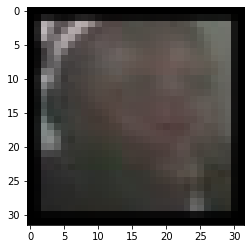

LSUN_resize


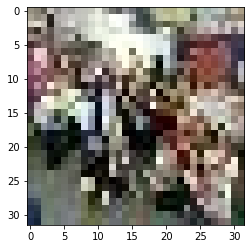

Imagenet


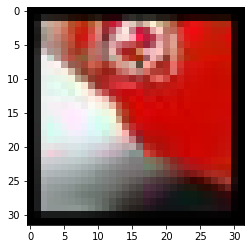

Imagenet_resize


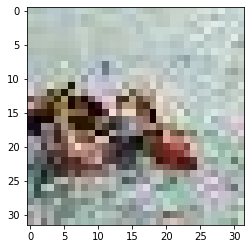

iSUN


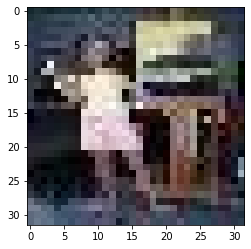

In [130]:
for name, ds in zip(datasets, test_ds):
    image = next(iter(ds.take(1)))
    print(name)
    plt.imshow(image[0].numpy())
    plt.show()

### Artificial Datasets

In [136]:
N_BATCHES = 1

x = tf.random.normal(shape=(BATCHSIZE*N_BATCHES, 32,32,3) , mean=0.5, stddev=1.0)
x = tf.clip_by_value(x, 0.0, 1.0)
gaussian_test_batches = tf.split(x, N_BATCHES)

x = tf.random.uniform(shape=(BATCHSIZE*N_BATCHES, 32,32,3), minval=0.0, maxval=1.0)
uniform_test_batches = tf.split(x, N_BATCHES)

In [137]:
artificial_ood = (gaussian_test_batches, uniform_test_batches)

In [138]:
%%time
for name, outlier in zip(["gaussian", "uniform"], artificial_ood):
    scores[name] = compute_weighted_scores(model,outlier)

Sigma: 0.0100: 100%|██████████| 232/232 [02:56<00:00,  1.32it/s]

CPU times: user 2min 29s, sys: 3min 25s, total: 5min 54s
Wall time: 5min 52s


In [139]:
scores.keys()

dict_keys(['LSUN', 'LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN', 'gaussian', 'uniform'])

In [140]:
scores["gaussian"].shape

TensorShape([512, 232])

In [22]:
# with open("svhn/scores_full_norm_test.p", "wb") as f:
#     pickle.dump(svhn_scores, f)

> ### 5% Held out Train

In [ ]:
with tf.device('CPU'):
    data_generators = tfds.load(name="svhn_cropped", batch_size=-1, data_dir="data", shuffle_files=True)
    svhn_test = tf.data.Dataset.from_tensor_slices(data_generators['train[-5%:]']["image"])
    svhn_test = svhn_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    svhn_test = svhn_test.batch(260)

### CIFAR 10.1

In [23]:
with tf.device('CPU'):
    data_generators = tfds.load(name="cifar10", batch_size=-1, data_dir="data", shuffle_files=True)
    cifar101_test = tf.data.Dataset.from_tensor_slices(data_generators['test']["image"])
    cifar101_test = cifar101_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    cifar101_test = cifar101_test.batch(512)

(array([415, 783, 297, 227, 194, 150,  95, 354, 389, 168]), array([0.        , 0.08627451, 0.17254902, 0.25882354, 0.34509805,
       0.43137255, 0.5176471 , 0.6039216 , 0.6901961 , 0.7764706 ,
       0.8627451 ], dtype=float32))


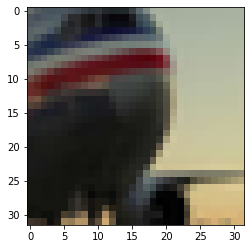

In [24]:
for imgs in cifar101_test.take(1):
    print(np.histogram(imgs[0]))
    plt.imshow(imgs[0].numpy())
    plt.show()

In [25]:
%%time
cifar101_scores = compute_scores(model, cifar101_test)

cifar101_scores = weighted_norm(cifar101_scores)

Sigma: 0.0100: 100%|██████████| 10/10 [00:37<00:00,  3.75s/it]


CPU times: user 15.6 s, sys: 11 s, total: 26.7 s
Wall time: 38.1 s


In [26]:
with open("cifar101_scores_ckpt-20.p", "wb") as f:
    pickle.dump(cifar101_scores, f)